# Example usage
We'll simulate microphone data using a package called `pyroomacoustics` then use MUSE to estimate the location.
The package `pyroomacoustics` allows us to generate a room, place mics and play a sound from arbitrary locations, and then simulate the signals that the mics would pick up.
First define some helper functions, `generate_room` and `place_mics` to handle those tasks easily.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.io import wavfile
from scipy.spatial import distance

import muse

from utils import generate_room, place_mics, add_source

In [2]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

# 1. Setup virtual environment
Using `pyroomacoustics`, simulate a rectangular room in which we'll place microphones and play a sound.

#### room parameters

In [3]:
sr = 125000 #audio sampling rate

#room dimensions
x_dim = 1.83
y_dim = 2.44
z_dim = 0.76

#microphone positions

#to place in top corners, otherwise, put in x,y,z coords 
offset = .1
mic_pos = np.array([
    [x_dim-offset, y_dim-offset, z_dim-offset],
    [offset, offset, z_dim-offset],
    [offset, y_dim-offset, z_dim-offset],
    [x_dim-offset, offset, z_dim-offset]
])

#pack stimulus to play in room
import os
sr_stimulus, stimulus = wavfile.read(os.path.abspath('../stimuli/tones/sine_2khz.wav'))

#position of speaker in room
x_pos, y_pos, z_pos = 0.8, 1.14, 0.01

#### generate room
Using a helper function defined in `utils.py`, create a `pyroomacoustics` room of the specified dimension.

In [15]:
room = generate_room(x_dim, y_dim, z_dim, sampling_rate=sr)

#### visualize room

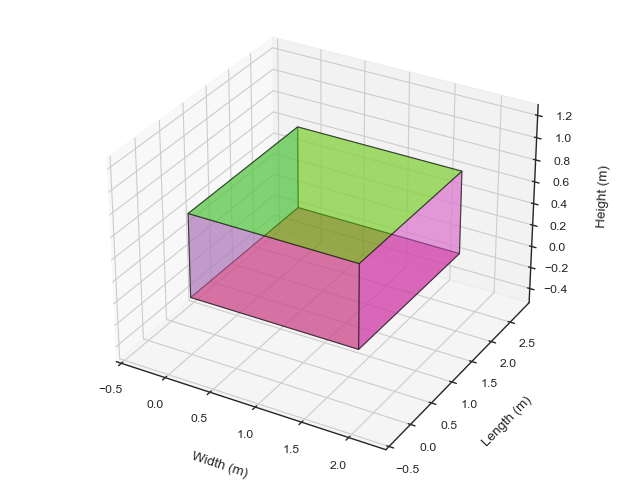

In [5]:
%matplotlib widget

axes_offset = 0.5

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper')

fig, ax = room.plot()
ax.set_xlim([-axes_offset, x_dim+axes_offset])
ax.set_ylim([-axes_offset, y_dim+axes_offset])
ax.set_zlim([-axes_offset, z_dim+axes_offset]);

ax.set_xlabel('Width (m)', labelpad=10)
ax.set_ylabel('Length (m)', labelpad=10)
ax.set_zlabel('Height (m)', labelpad=10);

#### add mics to room
Using another helper function, place four microphones into this room object at the specified positions.

In [6]:
place_mics(room, mic_pos)

#### vizualize mics in room

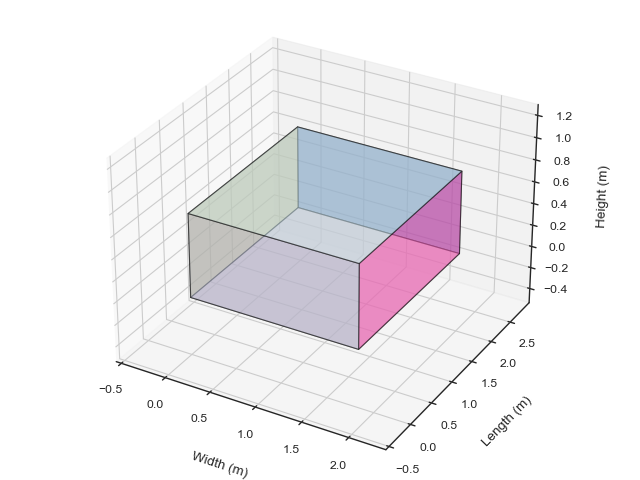

In [16]:
%matplotlib widget

axes_offset = 0.5

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper')

fig, ax = room.plot(plot_directivity=False, mic_marker_size=50)
ax.set_xlim([-axes_offset, x_dim+axes_offset])
ax.set_ylim([-axes_offset, y_dim+axes_offset])
ax.set_zlim([-axes_offset, z_dim+axes_offset]);

ax.set_xlabel('Width (m)', labelpad=10)
ax.set_ylabel('Length (m)', labelpad=10)
ax.set_zlabel('Height (m)', labelpad=10);

#### play a stimulus from a speaker
Pick a location `speaker_pos` from which to play the sound, then
add a `pyroomacoustics` audio source to the room at that location.

In [8]:
speaker_pos = (x_pos, y_pos, z_pos)
sr_stimulus, stimulus = add_source(speaker_pos, stimulus, sr_stimulus, room)

resampling audio


#### display speaker position

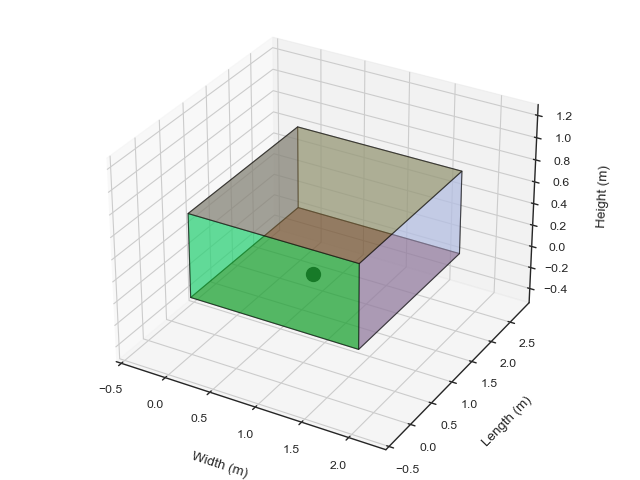

In [17]:
%matplotlib widget

axes_offset = 0.5

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper')

fig, ax = room.plot(plot_directivity=False, mic_marker_size=50)

ax.plot3D(x_pos, y_pos, z_pos, marker='o', color='k', markersize=10)

ax.set_xlim([-axes_offset, x_dim+axes_offset])
ax.set_ylim([-axes_offset, y_dim+axes_offset])
ax.set_zlim([-axes_offset, z_dim+axes_offset]);


ax.set_xlabel('Width (m)', labelpad=10)
ax.set_ylabel('Length (m)', labelpad=10)
ax.set_zlabel('Height (m)', labelpad=10);

#### run the simulation
Using `pyroomacoustics`, simulate the microphone data if the audio source we placed above played our chosen stimulus.

In [10]:
room.simulate()

#### output of the simunlation

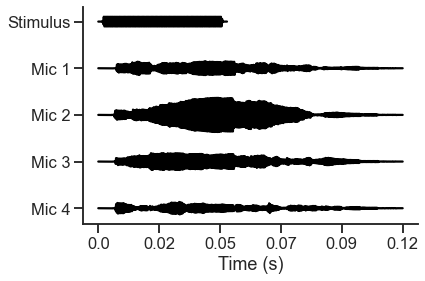

In [11]:
%matplotlib inline
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

tick_labels = ["Stimulus"]

plt.plot(stimulus, 'k')
for i in range(room.mic_array.signals.shape[0]):
    plt.plot(room.mic_array.signals[i]-(i+1)*10000, 'k')
    tick_labels.append('Mic {}'.format(i+1))

plt.xticks(np.arange(room.mic_array.signals.shape[1])[::int(room.mic_array.signals.shape[1]/5)],
       np.around(np.arange(room.mic_array.signals.shape[1])[::int(room.mic_array.signals.shape[1]/5)]/sr, decimals=2))
plt.yticks(np.arange(0,room.mic_array.signals.shape[0]+1)*-10000,
      tick_labels)
plt.xlabel('Time (s)')
sns.despine()

# 2. Run MUSE on simulated data

#### MUSE parameters

In [12]:
# audio from mic array from simulation
audio = room.mic_array.signals

# frequency range of interest
f_lo = 0
f_hi = 62500

fs = sr  # audio sampling rate
dt = 1 / fs  # time step
temp = 20  # temperature of environment (C)

n_mics, N = audio.shape

#### Run MUSE 
We'll use the Jacknife procedure as described in [(Warren, 2018)](https://pubmed.ncbi.nlm.nih.gov/29309793). To get our estimates, all we need to do is call the function `r_est_jacknife` on the parameters we've defined.

In [13]:
r_est, _, rsrp_grid = muse.r_est_jackknife(
    audio, fs, f_lo, f_hi, temp, x_dim, y_dim, 0.0025, mic_pos
    )

#### Visualize and compute error

MUSE error (m): 0.441


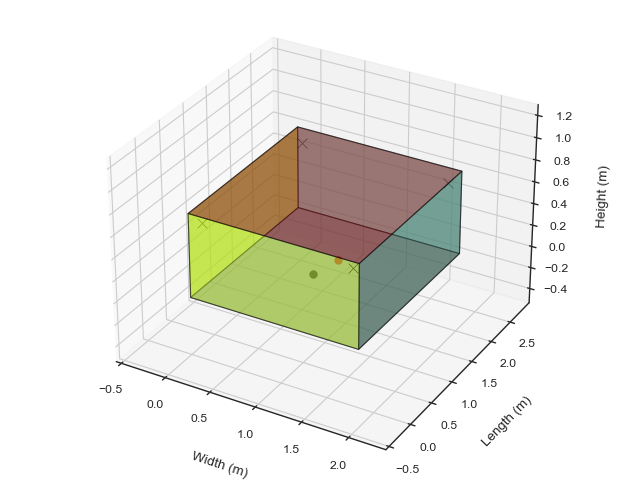

In [14]:
%matplotlib widget

axes_offset = 0.5

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper')

fig, ax = room.plot(plot_directivity=False, mic_marker_size=50,img_order=-1)


ax.plot3D(x_pos, y_pos, z_pos, marker='o', color='k', markersize=5)
ax.plot3D(r_est[0], r_est[1], 0, marker='o', color='r', markersize=5)

ax.set_xlim([-axes_offset, x_dim+axes_offset])
ax.set_ylim([-axes_offset, y_dim+axes_offset])
ax.set_zlim([-axes_offset, z_dim+axes_offset]);


ax.set_xlabel('Width (m)', labelpad=10)
ax.set_ylabel('Length (m)', labelpad=10)
ax.set_zlabel('Height (m)', labelpad=10);

print('MUSE error (m):', np.around(distance.euclidean(r_est, speaker_pos[:2]), decimals=3))